In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

#from model import PINN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [68]:

def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True,
                               allow_unused=True)



class NNBlock(nn.Module):
    """
    Standard Feed Forward Neural Network 
    """
    def __init__(self, in_chan, out_chan, chans=[5,10,5], dropout_prob=0.1):
        super().__init__()

        #self.in_block = nn.Linear(in_chan, chans[0])

        layers = []

        layers.append(nn.Linear(in_chan, chans[0]))
        layers.append(nn.Tanh())
        #layers.append(nn.Dropout(p=dropout_prob))

        for i in range(len(chans) - 1):
            layers.append(nn.Linear(chans[i], chans[i+1]))
            layers.append(nn.Tanh())
            #layers.append(nn.Dropout(p=dropout_prob))

        layers.append(nn.Linear(chans[-1], out_chan))

        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        #y = torch.sin(self.in_block(x))
        #return self.blocks(y)
    
        return self.blocks(x)


class PINN(nn.Module):
    """
    Physics Informed Neural Network. 
        * physical_loss :
            Calculates the physical loss using 
            - returns torch.tensor
    """
    def __init__(self, in_chan=1, out_chan=1, chans=[5,10,5]):
        super().__init__()
        self.nn = NNBlock(in_chan, out_chan, chans=chans)

        self.e_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        self.mu_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        self.M_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))

    def forward(self, x):
        mu = self.get_mu()
        M  = self.get_M()
        e  = self.get_e()
        u = mu/M * (1 + e*torch.cos(self.nn(x)))
        return u
    
    def get_e(self):
        #return torch.abs(self.e_)
        #return torch.tanh(torch.abs(self.e_[0]*self.e_[1] + self.e_[2]))
        return torch.abs(self.e_)
    
    def get_M(self):
        return torch.abs(self.M_)
        #return torch.exp(self.M_)
    
    def get_mu(self):
        return torch.abs(self.mu_)
        #return torch.exp(self.mu_)
    
    def get_p(self):
        return self.get_M()/self.get_mu()
        #return self.M_/self.mu_
        #return torch.exp(self.p_)

    def physical_loss(self, phi, lambda1=1., lambda2=1.):
        chi = self.nn(phi)

        mu = self.get_mu()#.detach()#.item()
        #M  = self.get_M()
        e  = self.get_e()#.item()

        #u = mu/M * (1 + e*torch.cos(chi))

        #dchi = grad(chi, phi)[0] # dchi/dphi = dchi/du * du/dphi = du/dphi * du/dchi
        #ddchi = grad(dchi, phi)[0]

        dchi = torch.autograd.grad(chi, phi, 
                               grad_outputs=torch.ones_like(chi), 
                               create_graph=True,
                               allow_unused=True)[0]
        
        ddchi = torch.autograd.grad(dchi, 
                               phi, 
                               grad_outputs=torch.ones_like(dchi), 
                               create_graph=True)[0]
    

        ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
        ode2 = ddchi - mu*e*torch.sin(chi)

        # L2 Loss
        loss1 = torch.mean(ode1**2)
        loss2 = torch.mean(ode2**2)

        # L1 Loss
        #loss1 = torch.mean(ode1)
        #loss2 = torch.mean(ode2)

        # Inverse loss
        #loss1 = torch.mean(1/(ode1 + 1e-6)**2)
        #loss2 = torch.mean(1/(ode2 + 1e-6)**2)
        
        loss1 *= lambda1
        loss2 *= lambda2

        return loss1 + loss2

In [69]:
class chi2(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, y):
        # x: predicted, y: target
        return torch.sum((x - y)**2/y)


class chiGINN(PINN):
    def __init__(self, in_chan, out_chan, chans):
        super().__init__(in_chan, out_chan, chans)
    
    def forward(self, x, mu_, M_, e_):
        mu = torch.abs(mu_)
        e = torch.abs(e_)
        M = torch.abs(M_)
        
        u = mu/M * (1 + e*torch.cos(self.nn(x)))
        return u



In [ ]:
state = torch.load("states/S2-GINN.pth")['model']
model = chiGINN(1, 1, chans=[16]*3).to(device)
model.load_state_dict(state)
model.eval();

criterion = chi2()

from src.SLoader import SLoader
loader = SLoader(scaling=1e-2)
phi = loader.phi
u = loader.u


dl = 0.01 # vary with 20%
N = 25

/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/src/SLoader.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(self.u, dtype=torch.float32)


In [71]:
e_ = model.e_.item()
M_ = model.M_.item()
mu_ = model.mu_.item()

e_arr = torch.linspace(e_*(1-dl), e_*(1+dl), steps=N)
M_arr = torch.linspace(M_*(1-dl), M_*(1+dl), steps=N)
mu_arr = torch.linspace(mu_*(1-dl), mu_*(1+dl), steps=N)

chi = torch.zeros((N,N,N))

for i, e in tqdm(enumerate(e_arr)):
    for j, M in enumerate(M_arr):
        for k, mu in enumerate(mu_arr):
            u_ = model(phi, mu, M, e)
            chi[i,j,k] = criterion(u_, u)
            


25it [00:03,  6.96it/s]


In [72]:
print(chi.shape)

torch.Size([25, 25, 25])


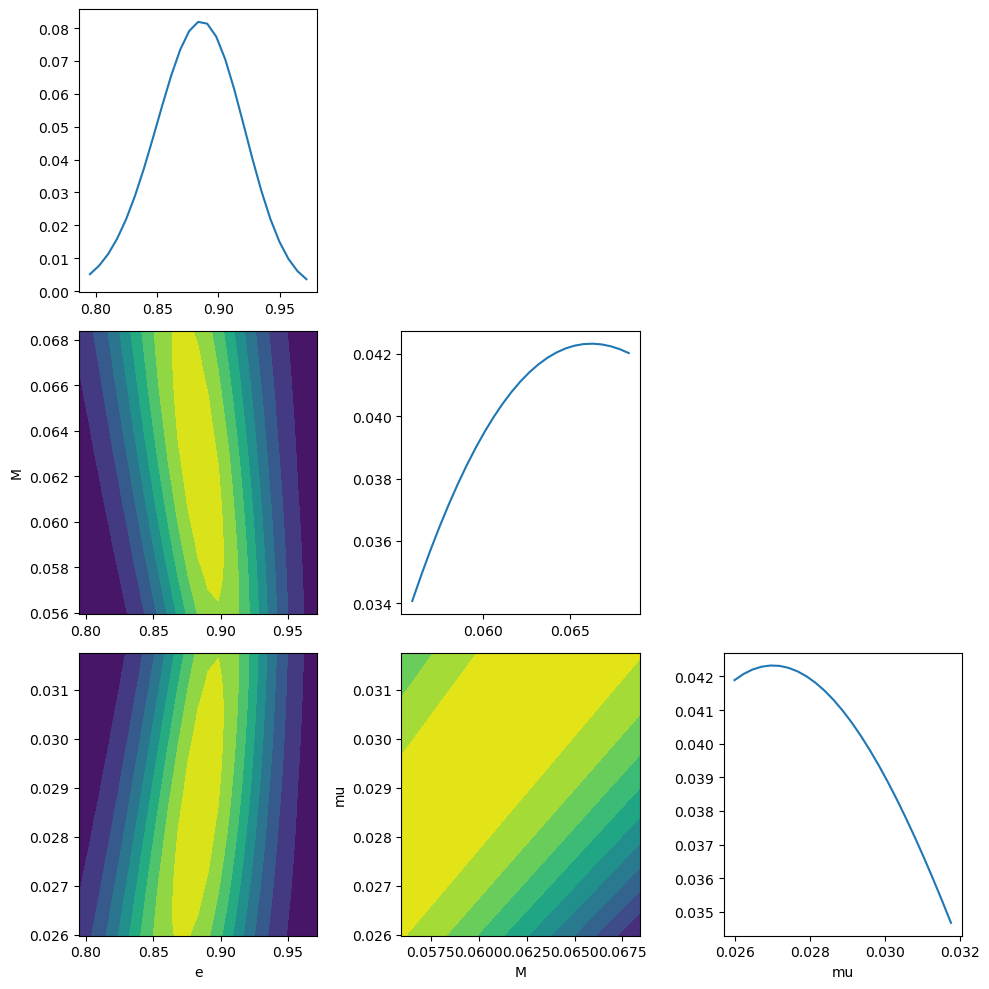

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Convert from "chi" (e.g. loss) to likelihood:
# Optional: normalize or exponentiate depending on interpretation
likelihood = torch.exp(-chi)  # if chi is loss-like
likelihood_np = likelihood.detach().numpy()

# Marginals
P_e = likelihood_np.sum(axis=(1,2))      # Marginal over M and mu
P_M = likelihood_np.sum(axis=(0,2))      # Marginal over e and mu
P_mu = likelihood_np.sum(axis=(0,1))     # Marginal over e and M

# 2D slices (joint)
P_eM = likelihood_np.sum(axis=2)         # Joint over e and M
P_emu = likelihood_np.sum(axis=1)        # Joint over e and mu
P_Mmu = likelihood_np.sum(axis=0)        # Joint over M and mu

# Normalize
P_e /= P_e.sum()
P_M /= P_M.sum()
P_mu /= P_mu.sum()
P_eM /= P_eM.sum()
P_emu /= P_emu.sum()
P_Mmu /= P_Mmu.sum()

# Create triangle plot manually
fig, axes = plt.subplots(3, 3, figsize=(10,10))

# Turn off unused plots
for i in range(3):
    for j in range(i+1, 3):
        axes[i, j].axis('off')

# 1D plots
axes[0,0].plot(e_arr.numpy(), P_e)
axes[1,1].plot(M_arr.numpy(), P_M)
axes[2,2].plot(mu_arr.numpy(), P_mu)

# 2D plots
e_grid, M_grid = torch.meshgrid(e_arr, M_arr, indexing='ij')
axes[1,0].contourf(e_grid.numpy(), M_grid.numpy(), P_eM, levels=10)
axes[2,0].contourf(e_grid.numpy(), mu_arr.numpy()[None,:]*np.ones_like(e_grid.numpy()), P_emu, levels=10)
axes[2,1].contourf(M_arr.numpy()[None,:]*np.ones_like(e_grid.numpy()), mu_arr.numpy()[:,None]*np.ones_like(M_arr.numpy()[None,:]), P_Mmu, levels=10)

# Label axes
axes[2,0].set_xlabel("e")
axes[1,0].set_ylabel("M")
axes[2,1].set_ylabel("mu")
axes[2,1].set_xlabel("M")
axes[2,2].set_xlabel("mu")

plt.tight_layout()
plt.show()
